## Table of Contents
0. Initial Setup
1. Utility Functions
2. Community Detection on Synthetic Networks
   - 2.1 Load Networks
   - 2.2 Community Detection Algorithms
   - 2.3 Evaluation Metrics
   - 2.4 Visualization
   - 2.5 Discussion
3. Conclusions

## 0. Initial Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
from collections import Counter
from cdlib import evaluation
import community as community_louvain
from tqdm import tqdm
from itertools import combinations
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community.quality import modularity

try:
    import infomap
except:
    !pip install infomap
    import infomap

plt.style.use('ggplot')
%matplotlib inline

REPORT_FOLDER = "report"
PLOTS_FOLDER = "plots"

for folder in [REPORT_FOLDER, PLOTS_FOLDER]:
    if not os.path.exists(folder):
        os.makedirs(folder)

## 1. Utility Functions

In [11]:
def load_network(path):
    """
    Load a Pajek-format network and convert to simple undirected NetworkX graph.

    Parameters:
        path (str): Path to .net file.

    Returns:
        G (networkx.Graph): Cleaned graph with integer-labeled nodes.
    """
    G = nx.read_pajek(path)
    G = nx.Graph(G)
    G = nx.convert_node_labels_to_integers(G)
    return G


def detect_communities_infomap(G):
    """
    Apply Infomap algorithm to detect communities in G.

    Parameters:
        G (networkx.Graph): Input graph.

    Returns:
        communities (list[set]): Detected communities.
    """
    im = infomap.Infomap()
    mapping = im.add_networkx_graph(G)
    im.run()
    modules = im.get_modules()
    community_dict = defaultdict(set)
    for node, com in modules.items():
        community_dict[com].add(mapping[node])
    return list(community_dict.values())


def detect_communities_louvain(G):
    """
    Apply Louvain algorithm to detect communities in G using NetworkX interface.

    Parameters:
        G (networkx.Graph): Input graph.

    Returns:
        communities (list[set]): Detected communities.
    """
    return list(nx.community.louvain_communities(G))


def detect_communities_greedy(G):
    """
    Apply Greedy modularity algorithm to detect communities in G.

    Parameters:
        G (networkx.Graph): Input graph.

    Returns:
        communities (list[set]): Detected communities.
    """
    return list(greedy_modularity_communities(G))


def evaluate_partitions(detected, ground_truth):
    """
    Compute evaluation metrics for a detected partition against ground truth.

    Parameters:
        detected (list[set]): Detected communities.
        ground_truth (list[set]): Ground-truth communities.

    Returns:
        dict: Scores for NMI, ARI, NVI.
    """
    return {
        "NMI": evaluation.normalized_mutual_information(detected, ground_truth).score,
        "ARI": evaluation.adjusted_rand_index(detected, ground_truth).score,
        "NVI": evaluation.normalized_variation_of_information(detected, ground_truth).score,
    }


def ground_truth_partition(N=300, block_size=60):
    """
    Generate the ground-truth partition from known SBM structure.

    Parameters:
        N (int): Total number of nodes.
        block_size (int): Size of each block.

    Returns:
        list[set]: Ground truth communities.
    """
    return [set(range(i * block_size, (i + 1) * block_size)) for i in range(N // block_size)]

## 2. Community Detection on Synthetic Networks

### 2.1 Load Networks
We load all synthetic networks from the folder `data/`, generated according to the Stochastic Block Model. Each network has 300 nodes and 5 blocks. The only parameter that changes is `prr`, ranging from 0.02 to 1.00.

Each filename has the form:
`synthetic_network_N_300_blocks_5_prr_{value}_prs_0.02.net`

In [3]:
from glob import glob
import re

networks = {}

for path in sorted(glob("data/*.net")):
    match = re.search(r"prr_([0-9.]+)_prs", path)
    if match:
        prr = float(match.group(1))
        networks[prr] = load_network(path)

networks = dict(sorted(networks.items()))  # Sort by prr


### 2.2 Community Detection Algorithms
We now apply Infomap, Louvain, and Greedy modularity maximization to each synthetic network.

In [ ]:
communities_infomap = {}
communities_louvain = {}
communities_greedy = {}
modularity_infomap = {}
modularity_louvain = {}
modularity_greedy = {}

for prr, G in tqdm(networks.items(), desc="Detecting communities"):
    communities_infomap[prr] = detect_communities_infomap(G)
    communities_louvain[prr] = detect_communities_louvain(G)
    communities_greedy[prr] = detect_communities_greedy(G)

    modularity_infomap[prr] = modularity(G, communities_infomap[prr])
    modularity_louvain[prr] = modularity(G, communities_louvain[prr])
    modularity_greedy[prr] = modularity(G, communities_greedy[prr])


### 2.3 Evaluation Metrics
We now compare the detected partitions with the ground truth using the following metrics:
- Normalized Mutual Information (NMI)
- Adjusted Rand Index (ARI)
- Normalized Variation of Information (NVI)

In [9]:
evaluation_scores_infomap = {}
evaluation_scores_louvain = {}
evaluation_scores_greedy = {}

ground_truth = ground_truth_partition()

for prr, G in tqdm(networks.items(), desc="Evaluating partitions"):
    evaluation_scores_infomap[prr] = evaluate_partitions(G, communities_infomap[prr], ground_truth)
    evaluation_scores_louvain[prr] = evaluate_partitions(G, communities_louvain[prr], ground_truth)
    evaluation_scores_greedy[prr] = evaluate_partitions(G, communities_greedy[prr], ground_truth)

Evaluating partitions:   0%|          | 0/50 [00:00<?, ?it/s]


TypeError: normalized_mutual_information() takes 2 positional arguments but 3 were given

### 2.3.1 Plots: Number of Communities and Evaluation Scores vs prr

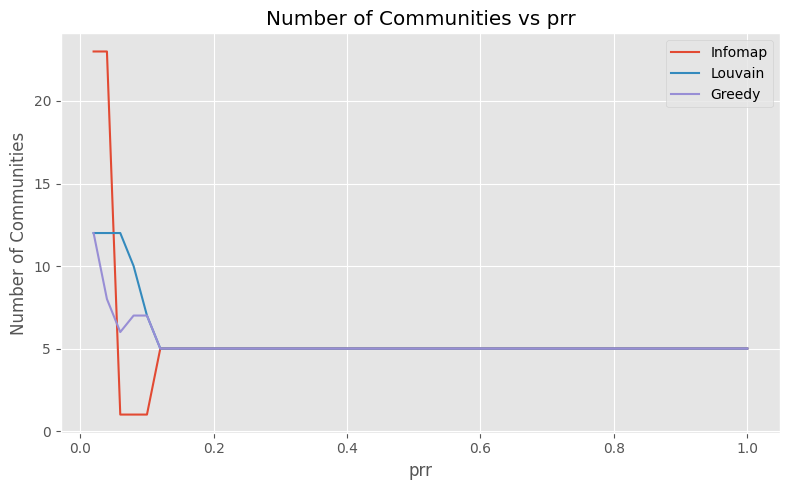

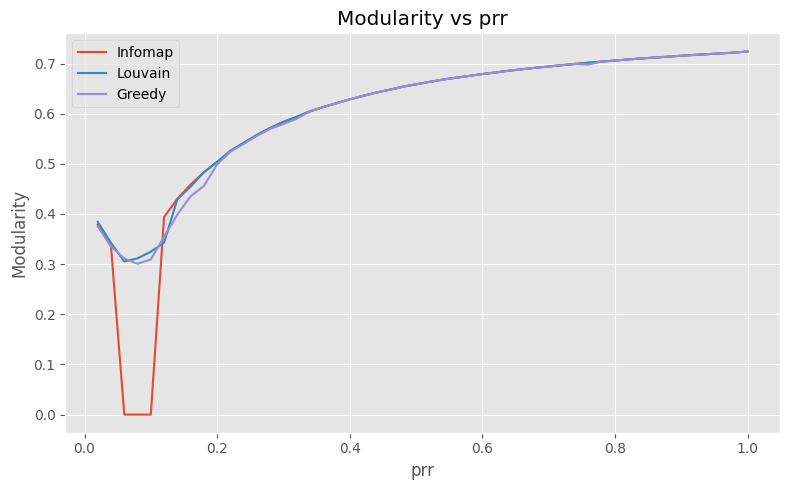

KeyError: 0.02

<Figure size 800x500 with 0 Axes>

In [13]:
prr_values = list(networks.keys())

# Plot: Number of communities vs prr
plt.figure(figsize=(8, 5))
plt.plot(prr_values, [len(communities_infomap[p]) for p in prr_values], label='Infomap')
plt.plot(prr_values, [len(communities_louvain[p]) for p in prr_values], label='Louvain')
plt.plot(prr_values, [len(communities_greedy[p]) for p in prr_values], label='Greedy')
plt.xlabel("prr")
plt.ylabel("Number of Communities")
plt.title("Number of Communities vs prr")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{PLOTS_FOLDER}/num_communities_vs_prr.png")
plt.show()

# Plot: Modularity vs prr
plt.figure(figsize=(8, 5))
plt.plot(prr_values, [modularity_infomap[p] for p in prr_values], label='Infomap')
plt.plot(prr_values, [modularity_louvain[p] for p in prr_values], label='Louvain')
plt.plot(prr_values, [modularity_greedy[p] for p in prr_values], label='Greedy')
plt.xlabel("prr")
plt.ylabel("Modularity")
plt.title("Modularity vs prr")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{PLOTS_FOLDER}/modularity_vs_prr.png")
plt.show()

# Plot: NMI vs prr
plt.figure(figsize=(8, 5))
plt.plot(prr_values, [evaluation_scores_infomap[p]['NMI'] for p in prr_values], label='Infomap')
plt.plot(prr_values, [evaluation_scores_louvain[p]['NMI'] for p in prr_values], label='Louvain')
plt.plot(prr_values, [evaluation_scores_greedy[p]['NMI'] for p in prr_values], label='Greedy')
plt.xlabel("prr")
plt.ylabel("NMI")
plt.title("Normalized Mutual Information vs prr")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{PLOTS_FOLDER}/nmi_vs_prr.png")
plt.show()

# Plot: ARI vs prr
plt.figure(figsize=(8, 5))
plt.plot(prr_values, [evaluation_scores_infomap[p]['ARI'] for p in prr_values], label='Infomap')
plt.plot(prr_values, [evaluation_scores_louvain[p]['ARI'] for p in prr_values], label='Louvain')
plt.plot(prr_values, [evaluation_scores_greedy[p]['ARI'] for p in prr_values], label='Greedy')
plt.xlabel("prr")
plt.ylabel("ARI")
plt.title("Adjusted Rand Index vs prr")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{PLOTS_FOLDER}/ari_vs_prr.png")
plt.show()

# Plot: NVI vs prr
plt.figure(figsize=(8, 5))
plt.plot(prr_values, [evaluation_scores_infomap[p]['NVI'] for p in prr_values], label='Infomap')
plt.plot(prr_values, [evaluation_scores_louvain[p]['NVI'] for p in prr_values], label='Louvain')
plt.plot(prr_values, [evaluation_scores_greedy[p]['NVI'] for p in prr_values], label='Greedy')
plt.xlabel("prr")
plt.ylabel("NVI")
plt.title("Normalized Variation of Information vs prr")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{PLOTS_FOLDER}/nvi_vs_prr.png")
plt.show()
